### aim: 

### date: 

In [86]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [87]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [88]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

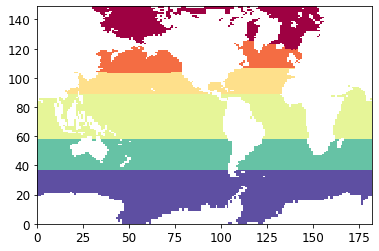

In [89]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

mask_latbands = np.copy(maskno)

mask_latbands[maskno == 0.5] = 1
mask_latbands[(maskno == 1) | (maskno == 2.4)] = 2
mask_latbands[(maskno == 1.2) | (maskno == 2.6)] = 3
mask_latbands[(maskno == 1.4) | (maskno == 2.8) | (maskno == 3.6)] = 4
mask_latbands[(maskno == 1.6) | (maskno == 3.0) | (maskno == 3.8)] = 5
mask_latbands[(maskno == 1.8) | (maskno == 3.2) | (maskno == 4.0)] = 6

plt.figure()
plt.pcolormesh(mask_latbands, cmap = 'Spectral')

In [90]:
sc = {
    'GEA3': {
        'name': 'ERA CAL12- dyn',
        'linestyle':'-',
        'color':'r',
        'runid':'TOM12_TJ_GEA3'},
    'GEC2': {
        'name': 'ERA CAL12- bias 1967',
        'linestyle':':',
        'color':'r',
        'runid':'TOM12_TJ_GEC2'},
    'GECB': {
        'name': 'ERA CAL12- bias 1990',
        'linestyle':'--',
        'color':'r',
        'runid':'TOM12_TJ_GECB'},
    
    'GNA2': {
        'name': 'NCEP CAL12- dyn',
        'linestyle':'-',
        'color':'k',
        'runid':'TOM12_TJ_GNA2'},    
    'GNC2': {
        'name': 'NCEP CAL12- bias 1967',
        'linestyle':':',
        'color':'k',
        'runid':'TOM12_TJ_GNC2'},    
    'GNCB': {
        'name': 'NCEP CAL12- bias 1990',
        'linestyle':'--',
        'color':'k',
        'runid':'TOM12_TJ_GNCB'},  
    
    'GNAP': {
        'name': 'NCEP CAL12- dyn (biology feedback on)',
        'linestyle':'-',
        'color':'grey',
        'runid':'TOM12_TJ_GNAP'},    
    'GNCP': {
        'name': 'NCEP CAL12- bias 1990 (biology feedback on)',
        'linestyle':'--',
        'color':'grey',
        'runid':'TOM12_TJ_GNCP'},    
    
    'GA01': {
        'name': 'NCEP DW2022 - dyn (biology feedback on)',
        'linestyle':'-',
        'color':'b',
        'runid':'TOM12_DW_GA01'},
    'GC01': {
        'name': 'NCEP DW2022 - bias 1990',
        'linestyle':'--',
        'color':'b',
        'runid':'TOM12_DW_GC01'},    
    'RVA0': {
        'name': 'ERA RIV12(GCB23) - dyn',
        'linestyle':'-',
        'color':'y',
        'runid':'TOM12_TJ_RVA0'},
    'RVC0': {
        'name': 'ERA RIV12(GCB23) - bias 1990',
        'linestyle':'--',
        'color':'y',
        'runid':'TOM12_TJ_RVC0'},    
    
}



In [91]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir ='/gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/extracted/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}-{dtype}-{yrs[i]}.nc'

        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist


In [92]:
def subtract_lines(tsc, tsc2, yrst, yren, ind, tlin = '-'):

    tds = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc]['runid']))
    tds2 = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc2]['runid']))

    axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean()-
                tds2[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
               color = sc[tsc]['color'], linestyle = tlin)

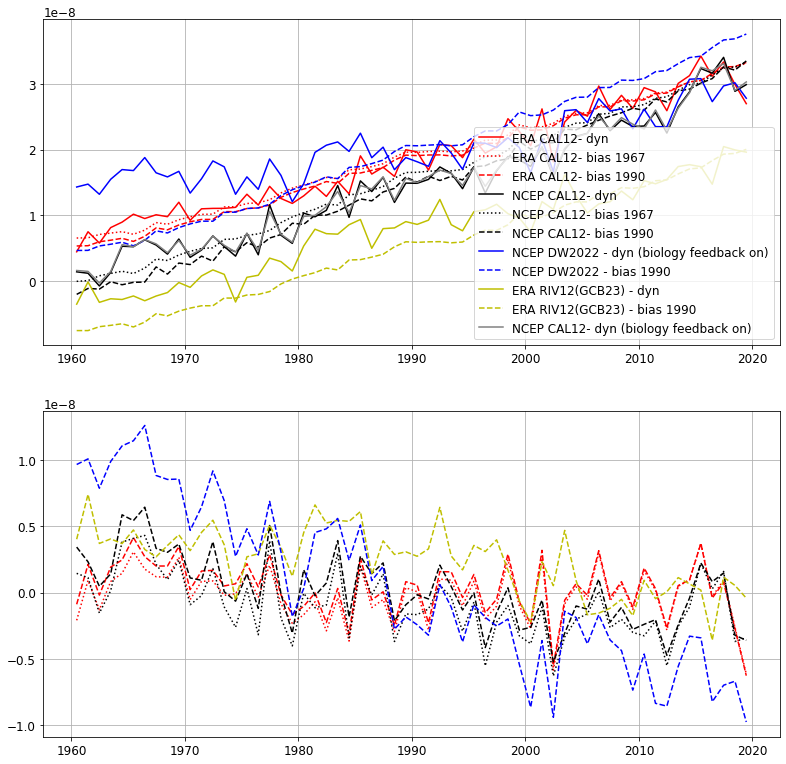

In [93]:
tvar = 'Cflx'

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

### all lines
yrst = 1960; yren = 2019

scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01','RVA0','RVC0', 'GNAP']
for s in range(0,len(scens)):
    
    tsc = scens[s]

    tds = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc]['runid']))
    axs[0].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
               color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])

axs[0].legend(loc = 'best')

tsc = 'GEA3'; tsc2 = 'GEC2'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, ':')
tsc = 'GEA3'; tsc2 = 'GECB'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, '--')
tsc = 'GNA2'; tsc2 = 'GNC2'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, ':')
tsc = 'GNA2'; tsc2 = 'GNCB'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, '--')
tsc = 'RVA0'; tsc2 = 'RVC0'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, '--')
tsc = 'GA01'; tsc2 = 'GC01'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, '--')

# yrst = 1948; yren = 2021

# scens = ['GA01','GC01']
# for s in range(0,2):
    
#     tsc = scens[s]

#     tds = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc]['runid']))
#     axs[0].plot(tds.time_counter.groupby('time_counter.year').mean()\
#                 ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
#                color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])

# axs[0].legend(loc = 'best')

# tsc = 'GA01'; tsc2 = 'GC01'; 
# subtract_lines(tsc, tsc2, yrst, yren, 1, '--')

for i in range(0,2):
    
    axs[i].grid()

# axs[0].set_title('Cflx south of -50, mmol/m2/day')
# axs[1].set_title('DYN-BIAS (dashed line has bias year 1990, dotted 1967)')
# plt.savefig('./figs/Cflx-3runcomparison.jpg')

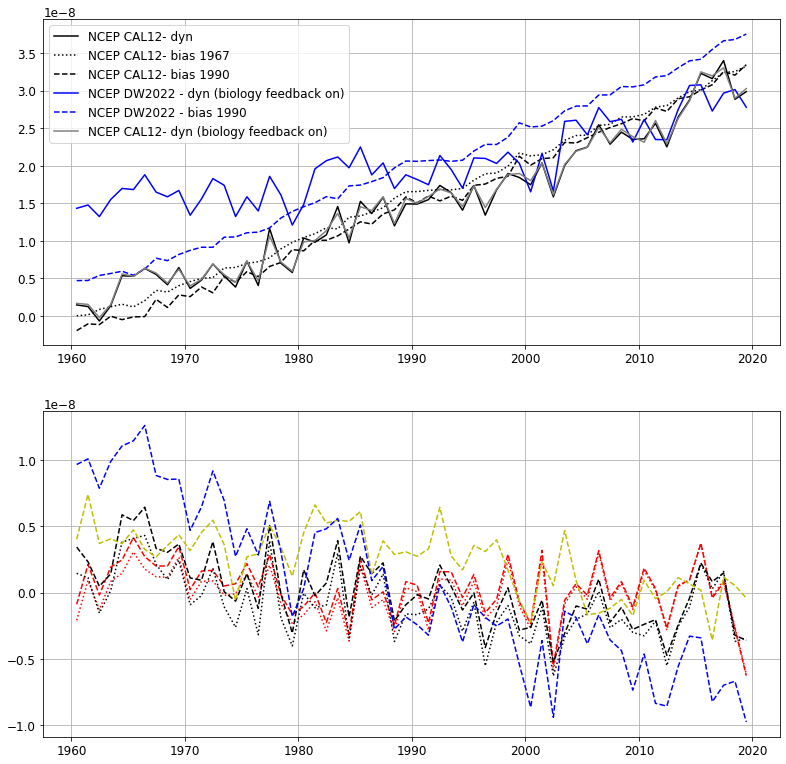

In [94]:
tvar = 'Cflx'

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

### all lines
yrst = 1960; yren = 2019

scens = ['GNA2','GNC2','GNCB','GA01','GC01','GNAP']
for s in range(0,len(scens)):
    
    tsc = scens[s]

    tds = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc]['runid']))
    axs[0].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
               color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])

axs[0].legend(loc = 'best')

tsc = 'GEA3'; tsc2 = 'GEC2'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, ':')
tsc = 'GEA3'; tsc2 = 'GECB'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, '--')
tsc = 'GNA2'; tsc2 = 'GNC2'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, ':')
tsc = 'GNA2'; tsc2 = 'GNCB'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, '--')
tsc = 'RVA0'; tsc2 = 'RVC0'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, '--')
tsc = 'GA01'; tsc2 = 'GC01'; 
subtract_lines(tsc, tsc2, yrst, yren, 1, '--')

# yrst = 1948; yren = 2021

# scens = ['GA01','GC01']
# for s in range(0,2):
    
#     tsc = scens[s]

#     tds = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc]['runid']))
#     axs[0].plot(tds.time_counter.groupby('time_counter.year').mean()\
#                 ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
#                color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])

# axs[0].legend(loc = 'best')

# tsc = 'GA01'; tsc2 = 'GC01'; 
# subtract_lines(tsc, tsc2, yrst, yren, 1, '--')

for i in range(0,2):
    
    axs[i].grid()

# axs[0].set_title('Cflx south of -50, mmol/m2/day')
# axs[1].set_title('DYN-BIAS (dashed line has bias year 1990, dotted 1967)')
# plt.savefig('./figs/Cflx-3runcomparison.jpg')

In [95]:
from scipy import stats
import pymannkendall as mk

def give_trends(ts_x,ts_y):
	trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
	lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
	return mk_slope, mk_p, lin_slope, lin_p

def get_subts(tsc, tsc2, yrst, yren, ind, tlin = '-'):

    tds = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc]['runid']))
    tds2 = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc2]['runid']))

    yrs = tds.time_counter.groupby('time_counter.year').mean()
    ts = tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean()-\
        tds2[tvar].sel(lat_band = 6).groupby('time_counter.year').mean()

    return yrs, ts

def get_trends(tsc, tsc2, tst, ten):
    yrs, ts = get_subts(tsc, tsc2, tst, ten, 1, ':')
    mk_slope, mk_p, lin_slope, lin_p = give_trends(np.arange(tst,ten+1),(ts.values))
    sig = ''
    if mk_p > 0.05:
        sig = 'NOT SIG'
    if lin_p > 0.05:
        sig = 'NOT SIG'
    name1 = sc[tsc]['name']
    name2 = sc[tsc2]['name']
    print(f'{tst}-{ten}: ({tsc}[{name1}] - {tsc2}[{name2}])')
    print(f'-----mann-kendall (/year):{sig} {mk_slope}')
    print(f'-----linear (/year):{sig} {lin_slope}')

In [96]:
print('')
print('- 1960-2019 -- -- --- -- --')
print('')
tst = 1960; ten = 2019
print(f'{tst}-{ten} Cflx DYN-BIAS trend for ERA-forced models')
tsc = 'GEA3'; tsc2 = 'GEC2'; 
get_trends(tsc, tsc2, tst, ten)
tsc = 'GEA3'; tsc2 = 'GECB'; 
get_trends(tsc, tsc2, tst, ten)
tsc = 'RVA0'; tsc2 = 'RVC0'; 
get_trends(tsc, tsc2, tst, ten)
print('')
print(f'{tst}-{ten} Cflx DYN-BIAS trend for NCEP-forced models')
tsc = 'GNA2'; tsc2 = 'GNC2'; 
get_trends(tsc, tsc2, tst, ten)
tsc = 'GNA2'; tsc2 = 'GNCB'; 
get_trends(tsc, tsc2, tst, ten)
tsc = 'GA01'; tsc2 = 'GC01'; 
get_trends(tsc, tsc2, tst, ten)
print('')
print('- 1980-2004 -- -- --- -- --')
print('')
tst = 1980; ten = 2004
print(f'{tst}-{ten} Cflx DYN-BIAS trend for ERA-forced models')
tsc = 'GEA3'; tsc2 = 'GEC2'; 
get_trends(tsc, tsc2, tst, ten)
tsc = 'GEA3'; tsc2 = 'GECB'; 
get_trends(tsc, tsc2, tst, ten)
tsc = 'RVA0'; tsc2 = 'RVC0'; 
get_trends(tsc, tsc2, tst, ten)
print('---')
print(f'{tst}-{ten} Cflx DYN-BIAS trend for NCEP-forced models')
tsc = 'GNA2'; tsc2 = 'GNC2'; 
get_trends(tsc, tsc2, tst, ten)
tsc = 'GNA2'; tsc2 = 'GNCB'; 
get_trends(tsc, tsc2, tst, ten)
tsc = 'GA01'; tsc2 = 'GC01'; 
get_trends(tsc, tsc2, tst, ten)


- 1960-2019 -- -- --- -- --

1960-2019 Cflx DYN-BIAS trend for ERA-forced models
1960-2019: (GEA3[ERA CAL12- dyn] - GEC2[ERA CAL12- bias 1967])
-----mann-kendall (/year):NOT SIG -1.6884823307382296e-11
-----linear (/year):NOT SIG -2.0283373582255014e-11
1960-2019: (GEA3[ERA CAL12- dyn] - GECB[ERA CAL12- bias 1990])
-----mann-kendall (/year): -3.533409565494168e-11
-----linear (/year): -3.919697109296786e-11
1960-2019: (RVA0[ERA RIV12(GCB23) - dyn] - RVC0[ERA RIV12(GCB23) - bias 1990])
-----mann-kendall (/year): -8.843510245155793e-11
-----linear (/year): -9.435105544340537e-11

1960-2019 Cflx DYN-BIAS trend for NCEP-forced models
1960-2019: (GNA2[NCEP CAL12- dyn] - GNC2[NCEP CAL12- bias 1967])
-----mann-kendall (/year): -7.039881002871553e-11
-----linear (/year): -6.899133230279033e-11
1960-2019: (GNA2[NCEP CAL12- dyn] - GNCB[NCEP CAL12- bias 1990])
-----mann-kendall (/year): -9.725588758193219e-11
-----linear (/year): -9.600670906400178e-11
1960-2019: (GA01[NCEP DW2022 - dyn (biology

In [97]:

# def plotind(tvar, ind, ttype, yrst = 1950,yren = 2019,):
#     scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01']
#     for s in range(0,8):

#         tsc = scens[s]

#         tds = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,sc[tsc]['runid']))
#         axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
#                     ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
#                    color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])
#     axs[0].legend(loc = 'best')


# fact = 1.1
# fig, axs = plt.subplots(3,2, figsize=(18*fact, 14*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# ### all lines
# yrst = 1948; yren = 2019



# tvar = 'pCO2'; ind = 0; ttype = 'diadT'

# scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01']
# for s in range(0,8):
    
#     tsc = scens[s]

#     tds = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc]['runid']))
#     axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
#                 ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
#                color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])
# axs[0].legend(loc = 'best')

# scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01']

# tvar = 'mldr10_1'; ttype = 'gridT'
# plotind(tvar, 1, ttype)

# tvar = 'PPINT'; ttype = 'diadT'
# plotind(tvar, 2, ttype)

# tvar = 'tos'; ttype = 'gridT'
# plotind(tvar, 3, ttype)

# tvar = 'sos'; ttype = 'gridT'
# plotind(tvar, 4, ttype)


# scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01']
# for s in range(0,8):
    
#     tsc = scens[s]

#     tds = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc]['runid']))
#     axs[5].plot(tds.time_counter.groupby('time_counter.year').mean()\
#                 ,(tds['surfTA'].sel(lat_band = 6).groupby('time_counter.year').mean()-
#                 tds['surfDIC'].sel(lat_band = 6).groupby('time_counter.year').mean())*1e6,
#                color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])
# axs[0].legend(loc = 'best')


# for i in range(0,6):
    
#     axs[i].grid()

## extract NCEP same way as ERA5...

interesting, NCEP has different taux tauy tendencies - solved, it's wind stress, different units.

In [98]:
def make_wspd(yr):
    
    sdir = '//gpfs/data/greenocean/software/products/NCEPForcingData/allyears/'
    yrpi = yr 
    #get and open
    fnam = f'taux_1d_y{yr}.nc' #taux_{yrpi}_daily.nc'
    taux_dat = xr.open_dataset(f'{sdir}{fnam}',decode_times=False)

    fnam = f'tauy_1d_y{yr}.nc'
    tauy_dat = xr.open_dataset(f'{sdir}{fnam}',decode_times=False)

    fnam_tosave = f'/gpfs/data/greenocean/software/resources/winds_gooddates/NCEP_wspd_{yr}_daily.nc'

    taux = taux_dat.uflx.values
    tauy = tauy_dat.vflx.values

    wspd = np.sqrt(taux**2 + tauy**2)

    times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='D',closed='left')
    #times = times[~((times.month == 2) & (times.day == 29))] #exclude leap yrs; nvm don't have to

    data_vars = {'wspd':(['time_counter', 'y', 'x'], wspd,
    {'units': 'm/s',
    'long_name':'wspd'}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], times),
    'nav_lat': (['y','x'], taux_dat.nav_lat.values),
    'nav_lon': (['y','x'], taux_dat.nav_lon.values),
    }
    # define global attributes
    attrs = {'made in':'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/wspdfromtauxtauy.py',
    'desc': 'remaking ukesm forcing with good dates so that we can analyze with xarray'
    }

    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(fnam_tosave)
    


def runner(yrstart, yrend):

    for yr in range(yrstart,yrend):
        print('miluju a maluju')
        make_wspd(yr)

    return 

# yrstart = 1950; yrend = 2020
# runner(yrstart, yrend)

In [99]:
def make_wspd2(yr):
    
    sdir = '//gpfs/data/greenocean/software/products/NCEPForcingData/allyears/'
    yrpi = yr 
    #get and open
    tdir = '/gpfs/data/greenocean/software/products/NCEPForcingData/'
    tfil = f'ncep_bulk_{yr}.nc'
    MO = xr.open_dataset(f'{tdir}{tfil}',decode_times=False)

    fnam_tosave = f'/gpfs/data/greenocean/software/resources/winds_gooddates/NCEP_wspd_frombulk_{yr}_daily.nc'


    times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='D',closed='left')
    #times = times[~((times.month == 2) & (times.day == 29))] #exclude leap yrs; nvm don't have to

    data_vars = {'wspd':(['time_counter', 'y', 'x'], MO.wspd,
    {'units': 'm/s',
    'long_name':'wspd'}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], times),
    'nav_lat': (['y','x'], taux_dat.nav_lat.values),
    'nav_lon': (['y','x'], taux_dat.nav_lon.values),
    }
    # define global attributes
    attrs = {'made in':'/gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/NCEP-ERA-comparison.ipynb',
    'desc': 'remaking ukesm forcing with good dates so that we can analyze with xarray'
    }

    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(fnam_tosave)
    


def runner(yrstart, yrend):

    for yr in range(yrstart,yrend):
        print(yr)
        make_wspd2(yr)

    return 



In [100]:
def make_yearlist_era_wspd(yrst, yrend, \
                  baseDir = '/gpfs/data/greenocean/software/resources/winds_gooddates/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/ERA5_v2022_wspd_{yrs[i]}_daily.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def make_yearlist_ncep_wspd(yrst, yrend, \
                  baseDir = '/gpfs/data/greenocean/software/resources/winds_gooddates/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/NCEP_wspd_frombulk_{yrs[i]}_daily.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

In [101]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
csize_broad = np.zeros([31,149,182])
for i in range(0,31):
        csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

In [102]:
winds_era = xr.open_mfdataset(make_yearlist_era_wspd(1960, 2019))
winds_ncep = xr.open_mfdataset(make_yearlist_ncep_wspd(1960, 2019))#, yrend,

In [103]:
winds_era_so = winds_era.sel(y=slice(0,37)).weighted(tmesh['csize'].\
                                                     sel(y=slice(0,37))).mean(dim = ['x','y']).groupby('time_counter.year').mean()
winds_ncep_so = winds_ncep.sel(y=slice(0,37)).weighted(tmesh['csize'].\
                                                       sel(y=slice(0,37))).mean(dim = ['x','y']).groupby('time_counter.year').mean()

In [104]:
winds_era_so_val = winds_era_so.wspd.values
winds_ncep_so_val = winds_ncep_so.wspd.values
yrs = winds_era_so.year.values

era_1990 = winds_era_so.isel(year = (winds_era_so.year == 1990)).wspd
era_1967 = winds_era_so.isel(year = (winds_era_so.year == 1967)).wspd
ncep_1990 = winds_ncep_so.isel(year = (winds_ncep_so.year == 1990)).wspd
ncep_1967 = winds_ncep_so.isel(year = (winds_ncep_so.year == 1967)).wspd

era_1990_ar = np.zeros(len(yrs))
era_1990_ar[:] = era_1990
era_1967_ar = np.zeros(len(yrs))
era_1967_ar[:] = era_1967
ncep_1990_ar = np.zeros(len(yrs))
ncep_1990_ar[:] = ncep_1990
ncep_1967_ar = np.zeros(len(yrs))
ncep_1967_ar[:] = ncep_1967



In [105]:
def subtract_lines(tsc, tsc2, yrst, yren, ind, ttype = 'diadT', tlin = '-', tvar = 'Cflx'):

    tds = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,sc[tsc]['runid']))
    tds2 = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,sc[tsc2]['runid']))

    axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean()-
                tds2[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
               color = sc[tsc]['color'], linestyle = tlin)
    
def subtract_lines_TADIC(tsc, tsc2, yrst, yren, ind, tlin = '-'):

    tds = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc]['runid']))
    tds2 = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc2]['runid']))
    
    tds['surfTADIC'] = (tds['surfTA']-tds['surfDIC'])*1e6
    tds2['surfTADIC'] = (tds2['surfTA']-tds2['surfDIC'])*1e6

    axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds['surfTADIC'].sel(lat_band = 6).groupby('time_counter.year').mean()-
                tds2['surfTADIC'].sel(lat_band = 6).groupby('time_counter.year').mean(),
               color = sc[tsc]['color'], linestyle = tlin)

        
    
def plotind(tvar, ind, ttype, yrst = 1960,yren = 2019):
    scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01','RVA0','RVC0']
    for s in range(0,10):

        tsc = scens[s]

        tds = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,sc[tsc]['runid']))
        axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
                    ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
                   color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])
    axs[0].legend(loc = 'best', ncol = 2, fontsize = 10)

## big plot of what is happening

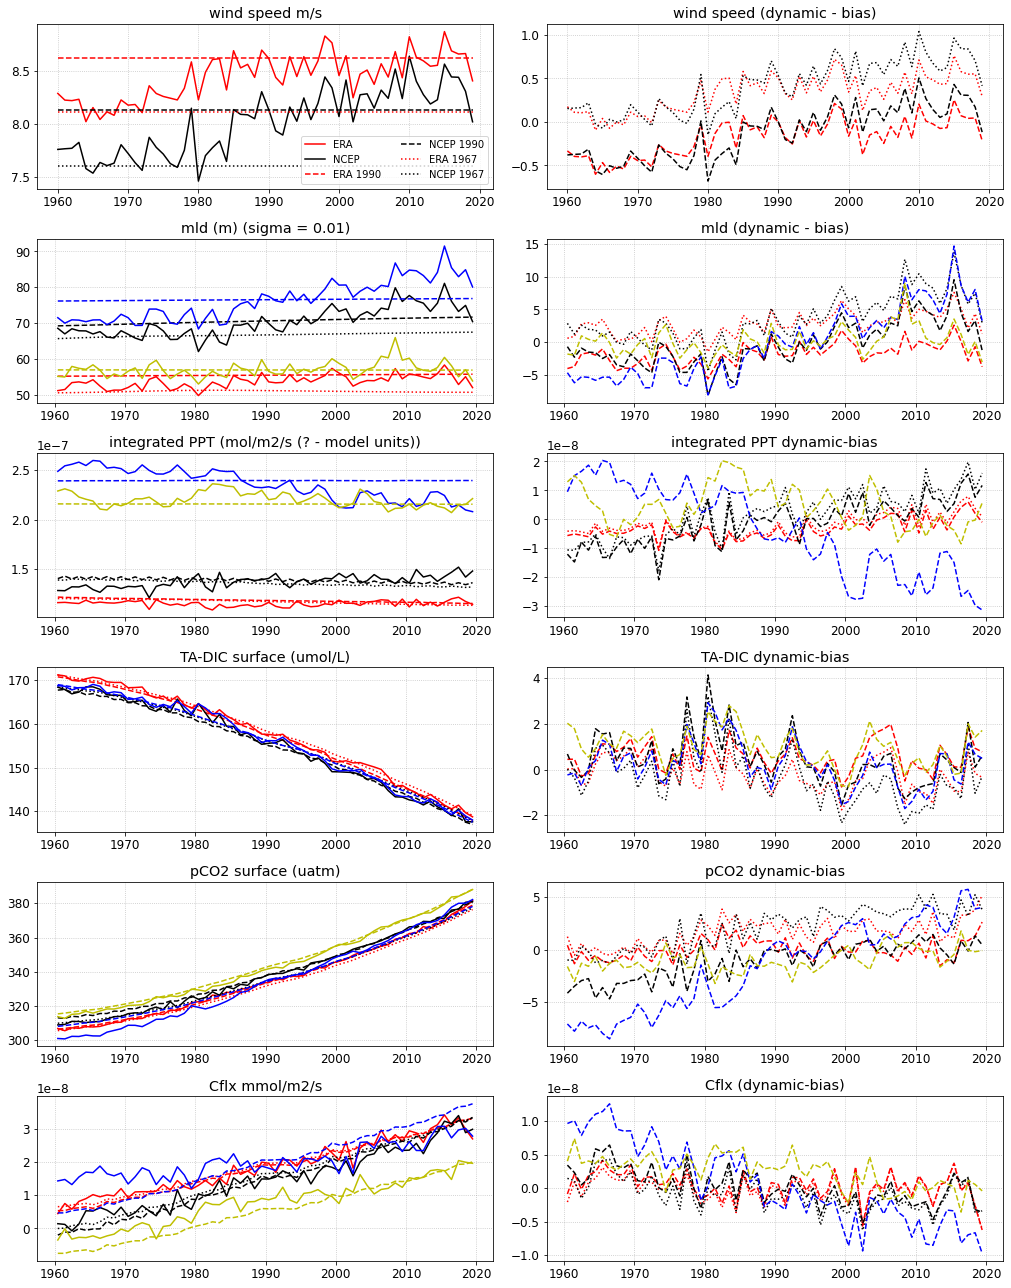

In [106]:

fact = 0.95
fig, axs = plt.subplots(6,2, figsize=(15*fact, 19*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(winds_era_so.year, winds_era_so_val , color = 'r', label = 'ERA')
axs[0].plot(winds_ncep_so.year,winds_ncep_so_val, color = 'k', label = 'NCEP')
axs[0].plot(winds_era_so.year, era_1990_ar, color = 'r', linestyle = '--', label = 'ERA 1990')
axs[0].plot(winds_ncep_so.year, ncep_1990_ar, color = 'k', linestyle = '--', label = 'NCEP 1990')
axs[0].plot(winds_era_so.year, era_1967_ar, color = 'r', linestyle = ':',label = 'ERA 1967')
axs[0].plot(winds_ncep_so.year, ncep_1967_ar, color = 'k', linestyle = ':',label = 'NCEP 1967')

axs[1].plot(winds_era_so.year, winds_era_so_val-era_1990_ar, color = 'r', linestyle = '--')
axs[1].plot(winds_era_so.year, winds_era_so_val-era_1967_ar, color = 'r', linestyle = ':')
axs[1].plot(winds_ncep_so.year, winds_ncep_so_val-ncep_1990_ar, color = 'k', linestyle = '--')
axs[1].plot(winds_ncep_so.year, winds_ncep_so_val-ncep_1967_ar, color = 'k', linestyle = ':')

tvar = 'mldr10_1'; ttype = 'gridT'
plotind(tvar, 2, ttype)
subtract_lines('GEA3', 'GEC2', 1960, 2019, 3, ttype = 'gridT', tlin = ':',tvar = 'mldr10_1')
subtract_lines('GEA3', 'GECB', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1')
subtract_lines('GNA2', 'GNC2', 1960, 2019, 3, ttype = 'gridT', tlin = ':',tvar = 'mldr10_1')
subtract_lines('GNA2', 'GNCB', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1')
subtract_lines('GA01', 'GC01', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1')
subtract_lines('RVA0', 'RVC0', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1')



tvar = 'PPINT'; ttype = 'diadT'
plotind(tvar, 4, ttype)
subtract_lines('GEA3', 'GEC2', 1960, 2019, 5, ttype = 'diadT', tlin = ':',tvar = 'PPINT')
subtract_lines('GEA3', 'GECB', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT')
subtract_lines('GNA2', 'GNC2', 1960, 2019, 5, ttype = 'diadT', tlin = ':',tvar = 'PPINT')
subtract_lines('GNA2', 'GNCB', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT')
subtract_lines('GA01', 'GC01', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT')
subtract_lines('RVA0', 'RVC0', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT')

###
scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01','RVA0', 'RVC0']
for s in range(0,8):

    tsc = scens[s]    
    tds = xr.open_mfdataset(make_yearlist(1960, 2019,'diadT',sc[tsc]['runid']))
    tds['surfTADIC'] = (tds['surfTA']-tds['surfDIC'])*1e6
    
    axs[6].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds['surfTADIC'].sel(lat_band = 6).groupby('time_counter.year').mean(),\
               color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])
    
subtract_lines_TADIC('GEA3', 'GEC2', 1960, 2019, 7,  tlin = ':',)
subtract_lines_TADIC('GEA3', 'GECB', 1960, 2019, 7,  tlin = '--',)
subtract_lines_TADIC('GNA2', 'GNC2', 1960, 2019, 7,  tlin = ':',)
subtract_lines_TADIC('GNA2', 'GNCB', 1960, 2019, 7,  tlin = '--',)
subtract_lines_TADIC('GA01', 'GC01', 1960, 2019, 7,  tlin = '--',)
subtract_lines_TADIC('RVA0', 'RVC0', 1960, 2019, 7,  tlin = '--',)

tvar = 'pCO2'; ttype = 'diadT'
plotind(tvar, 8, ttype)
subtract_lines('GEA3', 'GEC2', 1960, 2019, 9, ttype = 'diadT', tlin = ':',tvar = 'pCO2')
subtract_lines('GEA3', 'GECB', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2')
subtract_lines('GNA2', 'GNC2', 1960, 2019, 9, ttype = 'diadT', tlin = ':',tvar = 'pCO2')
subtract_lines('GNA2', 'GNCB', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2')
subtract_lines('GA01', 'GC01', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2')
subtract_lines('RVA0', 'RVC0', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2')


tvar = 'Cflx'; ttype = 'diadT'
plotind(tvar, 10, ttype, 1960, 2019)
subtract_lines('GEA3', 'GEC2', 1960, 2019, 11, ttype = 'diadT', tlin = ':', tvar = 'Cflx')
subtract_lines('GEA3', 'GECB', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx')
subtract_lines('GNA2', 'GNC2', 1960, 2019, 11, ttype = 'diadT', tlin = ':',tvar = 'Cflx')
subtract_lines('GNA2', 'GNCB', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx')
subtract_lines('GA01', 'GC01', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx')
subtract_lines('RVA0', 'RVC0', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx')


tits = ['wind speed m/s','wind speed (dynamic - bias)',\
        'mld (m) (sigma = 0.01)', 'mld (dynamic - bias)',\
        'integrated PPT (mol/m2/s (? - model units))','integrated PPT dynamic-bias',\
        'TA-DIC surface (umol/L)', 'TA-DIC dynamic-bias',\
        'pCO2 surface (uatm)', 'pCO2 dynamic-bias',\
        'Cflx mmol/m2/s', 'Cflx (dynamic-bias)']

for i in range(0,12):
    
    axs[i].grid(linestyle = ':', color = 'grey', alpha = 0.5)
    axs[i].set_title(tits[i])
    
plt.tight_layout()

plt.savefig('./figs/trends-FY.jpg')

## big plot of what is happening - summer

In [107]:
winds_era_so_DJF = winds_era.sel(time_counter=(winds_era['time_counter.season'] == 'DJF')).\
sel(y=slice(0,37)).weighted(tmesh['csize'].sel(y=slice(0,37))).\
mean(dim = ['x','y']).groupby('time_counter.year').mean()

winds_ncep_so_DJF = winds_ncep.sel(time_counter=(winds_ncep['time_counter.season'] == 'DJF')).\
sel(y=slice(0,37)).weighted(tmesh['csize'].sel(y=slice(0,37))).\
mean(dim = ['x','y']).groupby('time_counter.year').mean()

winds_era_so_DJF_val = winds_era_so_DJF.wspd.values
winds_ncep_so_DJF_val = winds_ncep_so_DJF.wspd.values
yrs = winds_era_so_DJF.year.values

era_1990_DJF = winds_era_so_DJF.isel(year = (winds_era_so_DJF.year == 1990)).wspd
era_1967_DJF = winds_era_so_DJF.isel(year = (winds_era_so_DJF.year == 1967)).wspd
ncep_1990_DJF = winds_ncep_so_DJF.isel(year = (winds_ncep_so_DJF.year == 1990)).wspd
ncep_1967_DJF = winds_ncep_so_DJF.isel(year = (winds_ncep_so_DJF.year == 1967)).wspd

era_1990_DJF_ar = np.zeros(len(yrs))
era_1990_DJF_ar[:] = era_1990_DJF
era_1967_DJF_ar = np.zeros(len(yrs))
era_1967_DJF_ar[:] = era_1967_DJF
ncep_1990_DJF_ar = np.zeros(len(yrs))
ncep_1990_DJF_ar[:] = ncep_1990_DJF
ncep_1967_DJF_ar = np.zeros(len(yrs))
ncep_1967_DJF_ar[:] = ncep_1967_DJF


In [108]:
def subtract_lines_seas(tsc, tsc2, yrst, yren, ind, ttype = 'diadT', tlin = '-', tvar = 'Cflx', seas = 'DJF'):

    tds = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,sc[tsc]['runid']))
    tds2 = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,sc[tsc2]['runid']))
    
    tds = tds.sel(time_counter=(tds['time_counter.season'] == seas))
    tds2 = tds2.sel(time_counter=(tds2['time_counter.season'] == seas))
    
    axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean()-
                tds2[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
               color = sc[tsc]['color'], linestyle = tlin)
 
def plotind_seas(tvar, ind, ttype, yrst = 1960,yren = 2019, seas = 'DJF'):
    scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01','RVA0','RVC0']
    for s in range(0,10):

        tsc = scens[s]

        tds = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,sc[tsc]['runid']))
        tds = tds.sel(time_counter=(tds['time_counter.season'] == seas))

        axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
                    ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean(),
                   color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])
    axs[0].legend(loc = 'best', ncol = 2, fontsize = 10)

def subtract_lines_seas_TADIC(tsc, tsc2, yrst, yren, ind, tlin = '-', seas = 'DJF'):

    tds = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc]['runid']))
    tds2 = xr.open_mfdataset(make_yearlist(yrst,yren,'diadT',sc[tsc2]['runid']))

    tds = tds.sel(time_counter=(tds['time_counter.season'] == seas))
    tds2 = tds2.sel(time_counter=(tds2['time_counter.season'] == seas))
    
    tds['surfTADIC'] = (tds['surfTA']-tds['surfDIC'])*1e6
    tds2['surfTADIC'] = (tds2['surfTA']-tds2['surfDIC'])*1e6

    axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds['surfTADIC'].sel(lat_band = 6).groupby('time_counter.year').mean()-
                tds2['surfTADIC'].sel(lat_band = 6).groupby('time_counter.year').mean(),
               color = sc[tsc]['color'], linestyle = tlin)

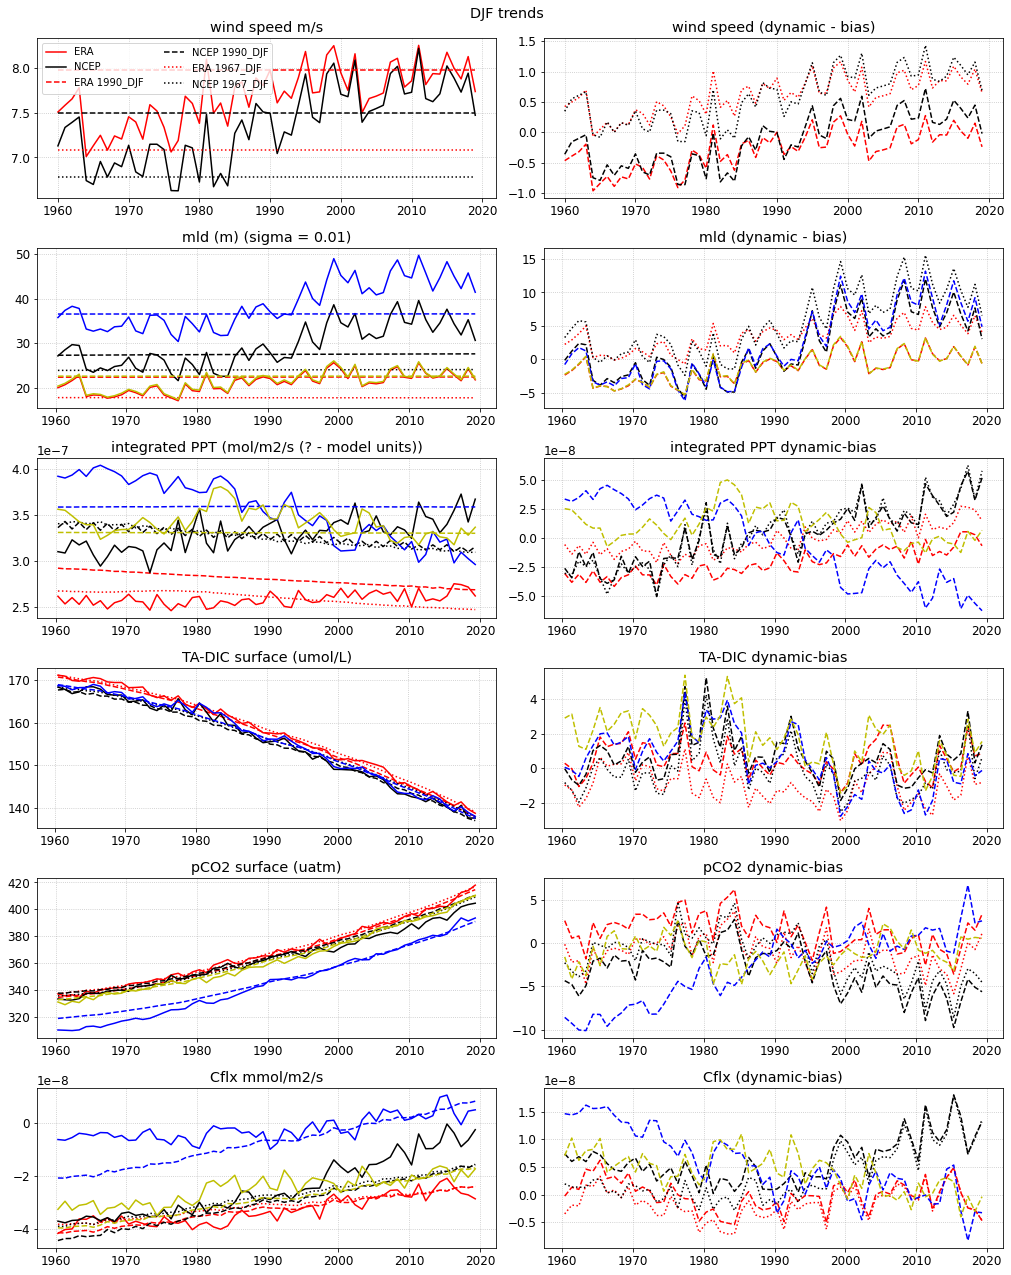

In [109]:

fact = 0.95
fig, axs = plt.subplots(6,2, figsize=(15*fact, 19*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(winds_era_so_DJF.year, winds_era_so_DJF_val , color = 'r', label = 'ERA')
axs[0].plot(winds_ncep_so_DJF.year,winds_ncep_so_DJF_val, color = 'k', label = 'NCEP')
axs[0].plot(winds_era_so_DJF.year, era_1990_DJF_ar, color = 'r', linestyle = '--', label = 'ERA 1990_DJF')
axs[0].plot(winds_ncep_so_DJF.year, ncep_1990_DJF_ar, color = 'k', linestyle = '--', label = 'NCEP 1990_DJF')
axs[0].plot(winds_era_so_DJF.year, era_1967_DJF_ar, color = 'r', linestyle = ':',label = 'ERA 1967_DJF')
axs[0].plot(winds_ncep_so_DJF.year, ncep_1967_DJF_ar, color = 'k', linestyle = ':',label = 'NCEP 1967_DJF')

axs[1].plot(winds_era_so_DJF.year, winds_era_so_DJF_val-era_1990_DJF_ar, color = 'r', linestyle = '--')
axs[1].plot(winds_era_so_DJF.year, winds_era_so_DJF_val-era_1967_DJF_ar, color = 'r', linestyle = ':')
axs[1].plot(winds_ncep_so_DJF.year, winds_ncep_so_DJF_val-ncep_1990_DJF_ar, color = 'k', linestyle = '--')
axs[1].plot(winds_ncep_so_DJF.year, winds_ncep_so_DJF_val-ncep_1967_DJF_ar, color = 'k', linestyle = ':')

tvar = 'mldr10_1'; ttype = 'gridT'
plotind_seas(tvar, 2, ttype, seas = 'DJF')
subtract_lines_seas('GEA3', 'GEC2', 1960, 2019, 3, ttype = 'gridT', tlin = ':',tvar = 'mldr10_1', seas = 'DJF')
subtract_lines_seas('GEA3', 'GECB', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1', seas = 'DJF')
subtract_lines_seas('GNA2', 'GNC2', 1960, 2019, 3, ttype = 'gridT', tlin = ':',tvar = 'mldr10_1', seas = 'DJF')
subtract_lines_seas('GNA2', 'GNCB', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1', seas = 'DJF')
subtract_lines_seas('GA01', 'GC01', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1',seas = 'DJF')
subtract_lines_seas('RVA0', 'RVC0', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1',seas = 'DJF')


tvar = 'PPINT'; ttype = 'diadT'
plotind_seas(tvar, 4, ttype, seas = 'DJF')
subtract_lines_seas('GEA3', 'GEC2', 1960, 2019, 5, ttype = 'diadT', tlin = ':',tvar = 'PPINT', seas = 'DJF')
subtract_lines_seas('GEA3', 'GECB', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT', seas = 'DJF')
subtract_lines_seas('GNA2', 'GNC2', 1960, 2019, 5, ttype = 'diadT', tlin = ':',tvar = 'PPINT',seas = 'DJF')
subtract_lines_seas('GNA2', 'GNCB', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT', seas = 'DJF')
subtract_lines_seas('GA01', 'GC01', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT', seas = 'DJF')
subtract_lines_seas('RVA0', 'RVC0', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT', seas = 'DJF')

###
scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01','RVA0', 'RVC0']
for s in range(0,8):

    tsc = scens[s]    
    tds = xr.open_mfdataset(make_yearlist(1960, 2019,'diadT',sc[tsc]['runid']))
    tds['surfTADIC'] = (tds['surfTA']-tds['surfDIC'])*1e6
    
    axs[6].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds['surfTADIC'].sel(lat_band = 6).groupby('time_counter.year').mean(),\
               color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])
    
subtract_lines_seas_TADIC('GEA3', 'GEC2', 1960, 2019, 7,  tlin = ':', seas = 'DJF')
subtract_lines_seas_TADIC('GEA3', 'GECB', 1960, 2019, 7,  tlin = '--', seas = 'DJF')
subtract_lines_seas_TADIC('GNA2', 'GNC2', 1960, 2019, 7,  tlin = ':', seas = 'DJF')
subtract_lines_seas_TADIC('GNA2', 'GNCB', 1960, 2019, 7,  tlin = '--', seas = 'DJF')
subtract_lines_seas_TADIC('GA01', 'GC01', 1960, 2019, 7,  tlin = '--', seas = 'DJF')
subtract_lines_seas_TADIC('RVA0', 'RVC0', 1960, 2019, 7,  tlin = '--', seas = 'DJF')

tvar = 'pCO2'; ttype = 'diadT'
plotind_seas(tvar, 8, ttype)
subtract_lines_seas('GEA3', 'GEC2', 1960, 2019, 9, ttype = 'diadT', tlin = ':',tvar = 'pCO2', seas = 'DJF')
subtract_lines_seas('GEA3', 'GECB', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2', seas = 'DJF')
subtract_lines_seas('GNA2', 'GNC2', 1960, 2019, 9, ttype = 'diadT', tlin = ':',tvar = 'pCO2', seas = 'DJF')
subtract_lines_seas('GNA2', 'GNCB', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2', seas = 'DJF')
subtract_lines_seas('GA01', 'GC01', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2', seas = 'DJF')
subtract_lines_seas('RVA0', 'RVC0', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2', seas = 'DJF')

tvar = 'Cflx'; ttype = 'diadT'
plotind_seas(tvar, 10, ttype, 1960, 2019)
subtract_lines_seas('GEA3', 'GEC2', 1960, 2019, 11, ttype = 'diadT', tlin = ':', tvar = 'Cflx', seas = 'DJF')
subtract_lines_seas('GEA3', 'GECB', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx', seas = 'DJF')
subtract_lines_seas('GNA2', 'GNC2', 1960, 2019, 11, ttype = 'diadT', tlin = ':',tvar = 'Cflx',seas = 'DJF')
subtract_lines_seas('GNA2', 'GNCB', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx', seas = 'DJF')
subtract_lines_seas('GA01', 'GC01', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx', seas = 'DJF')
subtract_lines_seas('RVA0', 'RVC0', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx', seas = 'DJF')

tits = ['wind speed m/s','wind speed (dynamic - bias)',\
        'mld (m) (sigma = 0.01)', 'mld (dynamic - bias)',\
        'integrated PPT (mol/m2/s (? - model units))','integrated PPT dynamic-bias',\
        'TA-DIC surface (umol/L)', 'TA-DIC dynamic-bias',\
        'pCO2 surface (uatm)', 'pCO2 dynamic-bias',\
        'Cflx mmol/m2/s', 'Cflx (dynamic-bias)']

for i in range(0,12):
    
    axs[i].grid(linestyle = ':', color = 'grey', alpha = 0.5)
    axs[i].set_title(tits[i])

plt.suptitle('DJF trends')
plt.tight_layout()

plt.savefig('./figs/trends-DJF.jpg')

In [110]:
winds_era_so_JJA = winds_era.sel(time_counter=(winds_era['time_counter.season'] == 'JJA')).\
sel(y=slice(0,37)).weighted(tmesh['csize'].sel(y=slice(0,37))).\
mean(dim = ['x','y']).groupby('time_counter.year').mean()

winds_ncep_so_JJA = winds_ncep.sel(time_counter=(winds_ncep['time_counter.season'] == 'JJA')).\
sel(y=slice(0,37)).weighted(tmesh['csize'].sel(y=slice(0,37))).\
mean(dim = ['x','y']).groupby('time_counter.year').mean()

winds_era_so_JJA_val = winds_era_so_JJA.wspd.values
winds_ncep_so_JJA_val = winds_ncep_so_JJA.wspd.values
yrs = winds_era_so_JJA.year.values

era_1990_JJA = winds_era_so_JJA.isel(year = (winds_era_so_JJA.year == 1990)).wspd
era_1967_JJA = winds_era_so_JJA.isel(year = (winds_era_so_JJA.year == 1967)).wspd
ncep_1990_JJA = winds_ncep_so_JJA.isel(year = (winds_ncep_so_JJA.year == 1990)).wspd
ncep_1967_JJA = winds_ncep_so_JJA.isel(year = (winds_ncep_so_JJA.year == 1967)).wspd

era_1990_JJA_ar = np.zeros(len(yrs))
era_1990_JJA_ar[:] = era_1990_JJA
era_1967_JJA_ar = np.zeros(len(yrs))
era_1967_JJA_ar[:] = era_1967_JJA
ncep_1990_JJA_ar = np.zeros(len(yrs))
ncep_1990_JJA_ar[:] = ncep_1990_JJA
ncep_1967_JJA_ar = np.zeros(len(yrs))
ncep_1967_JJA_ar[:] = ncep_1967_JJA


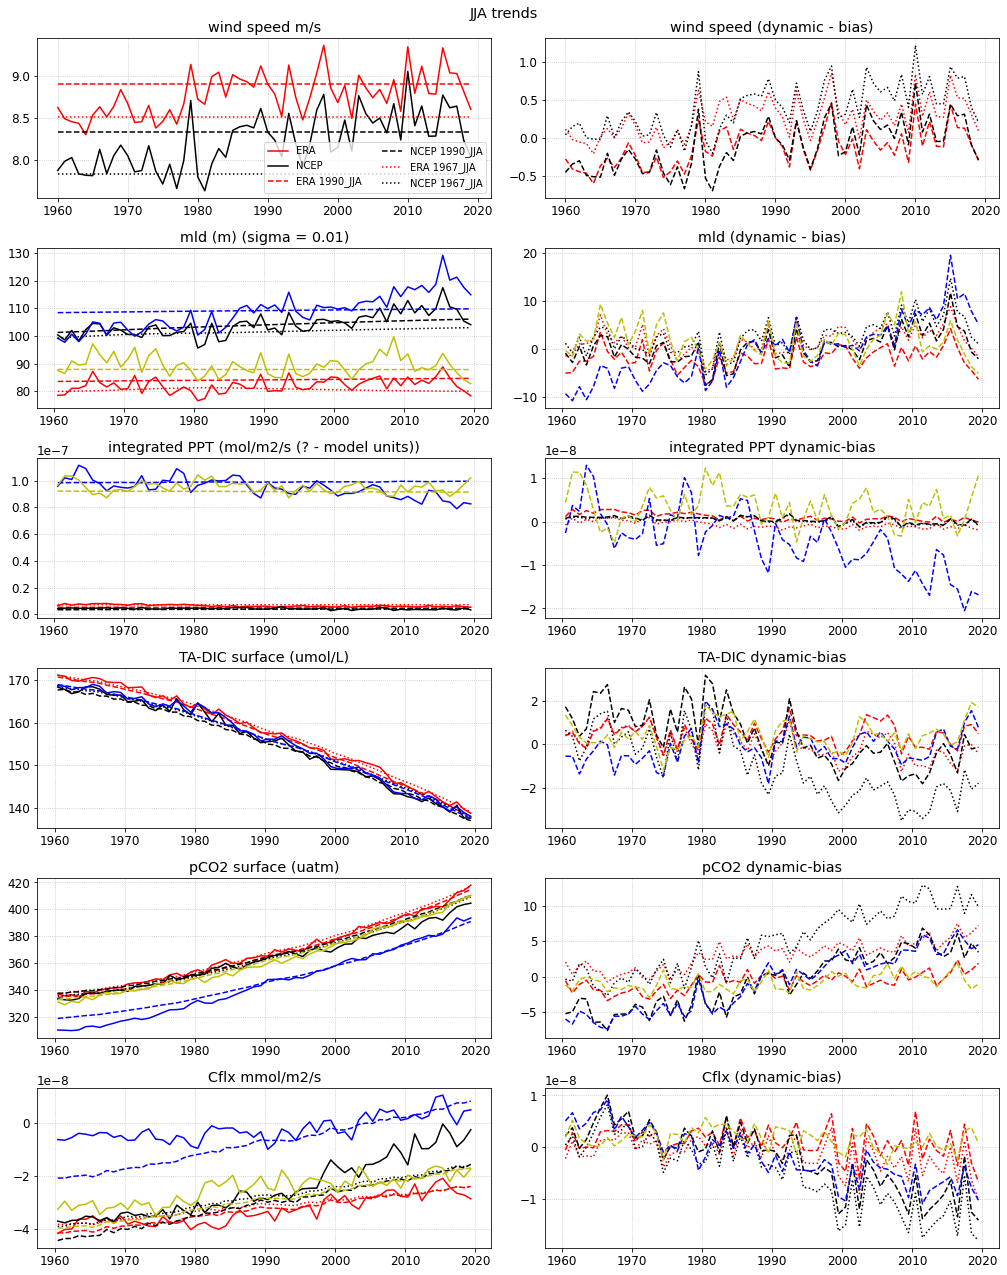

In [111]:

fact = 0.95
fig, axs = plt.subplots(6,2, figsize=(15*fact, 19*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(winds_era_so_JJA.year, winds_era_so_JJA_val , color = 'r', label = 'ERA')
axs[0].plot(winds_ncep_so_JJA.year,winds_ncep_so_JJA_val, color = 'k', label = 'NCEP')
axs[0].plot(winds_era_so_JJA.year, era_1990_JJA_ar, color = 'r', linestyle = '--', label = 'ERA 1990_JJA')
axs[0].plot(winds_ncep_so_JJA.year, ncep_1990_JJA_ar, color = 'k', linestyle = '--', label = 'NCEP 1990_JJA')
axs[0].plot(winds_era_so_JJA.year, era_1967_JJA_ar, color = 'r', linestyle = ':',label = 'ERA 1967_JJA')
axs[0].plot(winds_ncep_so_JJA.year, ncep_1967_JJA_ar, color = 'k', linestyle = ':',label = 'NCEP 1967_JJA')

axs[1].plot(winds_era_so_JJA.year, winds_era_so_JJA_val-era_1990_JJA_ar, color = 'r', linestyle = '--')
axs[1].plot(winds_era_so_JJA.year, winds_era_so_JJA_val-era_1967_JJA_ar, color = 'r', linestyle = ':')
axs[1].plot(winds_ncep_so_JJA.year, winds_ncep_so_JJA_val-ncep_1990_JJA_ar, color = 'k', linestyle = '--')
axs[1].plot(winds_ncep_so_JJA.year, winds_ncep_so_JJA_val-ncep_1967_JJA_ar, color = 'k', linestyle = ':')

tvar = 'mldr10_1'; ttype = 'gridT'
plotind_seas(tvar, 2, ttype, seas = 'JJA')
subtract_lines_seas('GEA3', 'GEC2', 1960, 2019, 3, ttype = 'gridT', tlin = ':',tvar = 'mldr10_1', seas = 'JJA')
subtract_lines_seas('GEA3', 'GECB', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1', seas = 'JJA')
subtract_lines_seas('GNA2', 'GNC2', 1960, 2019, 3, ttype = 'gridT', tlin = ':',tvar = 'mldr10_1', seas = 'JJA')
subtract_lines_seas('GNA2', 'GNCB', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1', seas = 'JJA')
subtract_lines_seas('GA01', 'GC01', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1',seas = 'JJA')
subtract_lines_seas('RVA0', 'RVC0', 1960, 2019, 3, ttype = 'gridT', tlin = '--',tvar = 'mldr10_1',seas = 'JJA')


tvar = 'PPINT'; ttype = 'diadT'
plotind_seas(tvar, 4, ttype, seas = 'JJA')
subtract_lines_seas('GEA3', 'GEC2', 1960, 2019, 5, ttype = 'diadT', tlin = ':',tvar = 'PPINT', seas = 'JJA')
subtract_lines_seas('GEA3', 'GECB', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT', seas = 'JJA')
subtract_lines_seas('GNA2', 'GNC2', 1960, 2019, 5, ttype = 'diadT', tlin = ':',tvar = 'PPINT',seas = 'JJA')
subtract_lines_seas('GNA2', 'GNCB', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT', seas = 'JJA')
subtract_lines_seas('GA01', 'GC01', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT', seas = 'JJA')
subtract_lines_seas('RVA0', 'RVC0', 1960, 2019, 5, ttype = 'diadT', tlin = '--',tvar = 'PPINT', seas = 'JJA')

###
scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01','RVA0', 'RVC0']
for s in range(0,8):

    tsc = scens[s]    
    tds = xr.open_mfdataset(make_yearlist(1960, 2019,'diadT',sc[tsc]['runid']))
    tds['surfTADIC'] = (tds['surfTA']-tds['surfDIC'])*1e6
    
    axs[6].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds['surfTADIC'].sel(lat_band = 6).groupby('time_counter.year').mean(),\
               color = sc[tsc]['color'], linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])
    
subtract_lines_seas_TADIC('GEA3', 'GEC2', 1960, 2019, 7,  tlin = ':', seas = 'JJA')
subtract_lines_seas_TADIC('GEA3', 'GECB', 1960, 2019, 7,  tlin = '--', seas = 'JJA')
subtract_lines_seas_TADIC('GNA2', 'GNC2', 1960, 2019, 7,  tlin = ':', seas = 'JJA')
subtract_lines_seas_TADIC('GNA2', 'GNCB', 1960, 2019, 7,  tlin = '--', seas = 'JJA')
subtract_lines_seas_TADIC('GA01', 'GC01', 1960, 2019, 7,  tlin = '--', seas = 'JJA')
subtract_lines_seas_TADIC('RVA0', 'RVC0', 1960, 2019, 7,  tlin = '--', seas = 'JJA')

tvar = 'pCO2'; ttype = 'diadT'
plotind_seas(tvar, 8, ttype)
subtract_lines_seas('GEA3', 'GEC2', 1960, 2019, 9, ttype = 'diadT', tlin = ':',tvar = 'pCO2', seas = 'JJA')
subtract_lines_seas('GEA3', 'GECB', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2', seas = 'JJA')
subtract_lines_seas('GNA2', 'GNC2', 1960, 2019, 9, ttype = 'diadT', tlin = ':',tvar = 'pCO2', seas = 'JJA')
subtract_lines_seas('GNA2', 'GNCB', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2', seas = 'JJA')
subtract_lines_seas('GA01', 'GC01', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2', seas = 'JJA')
subtract_lines_seas('RVA0', 'RVC0', 1960, 2019, 9, ttype = 'diadT', tlin = '--',tvar = 'pCO2', seas = 'JJA')

tvar = 'Cflx'; ttype = 'diadT'
plotind_seas(tvar, 10, ttype, 1960, 2019)
subtract_lines_seas('GEA3', 'GEC2', 1960, 2019, 11, ttype = 'diadT', tlin = ':', tvar = 'Cflx', seas = 'JJA')
subtract_lines_seas('GEA3', 'GECB', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx', seas = 'JJA')
subtract_lines_seas('GNA2', 'GNC2', 1960, 2019, 11, ttype = 'diadT', tlin = ':',tvar = 'Cflx',seas = 'JJA')
subtract_lines_seas('GNA2', 'GNCB', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx', seas = 'JJA')
subtract_lines_seas('GA01', 'GC01', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx', seas = 'JJA')
subtract_lines_seas('RVA0', 'RVC0', 1960, 2019, 11, ttype = 'diadT', tlin = '--',tvar = 'Cflx', seas = 'JJA')

tits = ['wind speed m/s','wind speed (dynamic - bias)',\
        'mld (m) (sigma = 0.01)', 'mld (dynamic - bias)',\
        'integrated PPT (mol/m2/s (? - model units))','integrated PPT dynamic-bias',\
        'TA-DIC surface (umol/L)', 'TA-DIC dynamic-bias',\
        'pCO2 surface (uatm)', 'pCO2 dynamic-bias',\
        'Cflx mmol/m2/s', 'Cflx (dynamic-bias)']

for i in range(0,12):
    
    axs[i].grid(linestyle = ':', color = 'grey', alpha = 0.5)
    axs[i].set_title(tits[i])

plt.suptitle('JJA trends')
plt.tight_layout()

plt.savefig('./figs/trends-JJA.jpg')

In [112]:
def plot_seas(tvar,ind,tmi,tma,typ):
    scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01','RVA0','RVC0']
    for s in range(0,10):

        tsc = scens[s]    
        tds = xr.open_mfdataset(make_yearlist(1950, 2019,typ,sc[tsc]['runid']))
        tds_b = tds.sel(time_counter=slice(f'1960-01-01', f'1970-01-01'))
        tds_e = tds.sel(time_counter=slice(f'2010-01-01', f'2020-01-01'))
        vb = tds_b[tvar].sel(lat_band = 6).groupby('time_counter.month').mean()
        ve = tds_e[tvar].sel(lat_band = 6).groupby('time_counter.month').mean()

        axs[ind].plot(vb.month,vb, color = sc[tsc]['color'], \
                      linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])
        axs[ind+1].plot(ve.month,ve, color = sc[tsc]['color'],
                        linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])

        for i in range(ind,ind+2):
            axs[i].set_ylim([tmi,tma])
            axs[i].set_xlim([1,12])
            axs[i].grid(alpha = 0.5)
            axs[i].axhline(y=0, color = 'g')

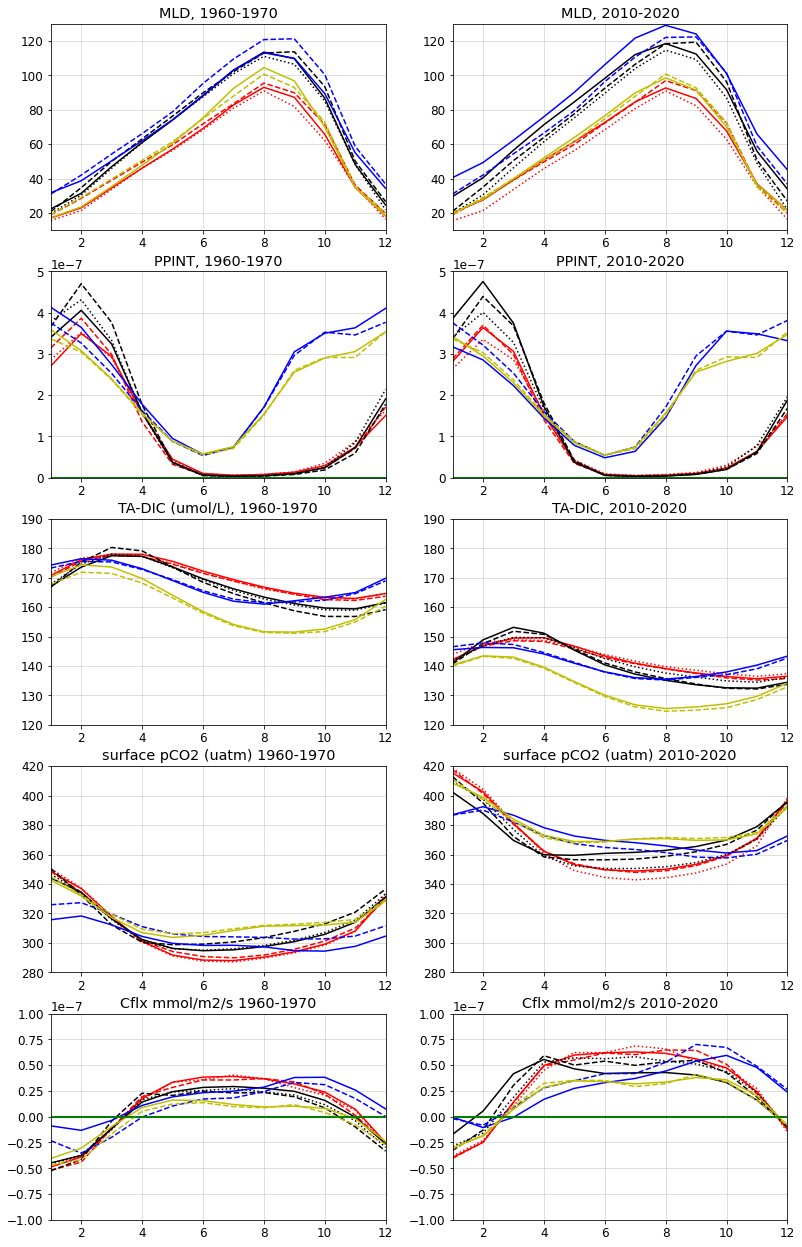

In [113]:
#mld, ppint, ta-dic, pco2, cflx
nfa = 5
fact = 1.1
fig, axs = plt.subplots(nfa,2, figsize=(12*fact, 4*fact*nfa), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvar = 'mldr10_1'; ind = 0; tmi = 10; tma = 130; typ = 'gridT'
plot_seas(tvar,ind,tmi,tma,typ)
          
tvar = 'PPINT'; ind = 2; tmi = 0; tma = 5e-7; typ = 'diadT'
plot_seas(tvar,ind,tmi,tma,typ)

ind = 4; tmi = 120; tma = 190;
scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01','RVA0','RVC0']
for s in range(0,10):

    tsc = scens[s]    
    tds = xr.open_mfdataset(make_yearlist(1960, 2019,typ,sc[tsc]['runid']))
    tds_b = tds.sel(time_counter=slice(f'1960-01-01', f'1970-01-01'))
    tds_e = tds.sel(time_counter=slice(f'2010-01-01', f'2020-01-01'))
    vb = (tds_b['surfTA'].sel(lat_band = 6).groupby('time_counter.month').mean()-
        tds_b['surfDIC'].sel(lat_band = 6).groupby('time_counter.month').mean())*1e6
    ve = (tds_e['surfTA'].sel(lat_band = 6).groupby('time_counter.month').mean()-
        tds_e['surfDIC'].sel(lat_band = 6).groupby('time_counter.month').mean())*1e6

    axs[ind].plot(vb.month,vb, color = sc[tsc]['color'], \
                  linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])
    axs[ind+1].plot(ve.month,ve, color = sc[tsc]['color'],
                    linestyle = sc[tsc]['linestyle'], label = sc[tsc]['name'])

    for i in range(ind,ind+2):
        axs[i].set_ylim([tmi,tma])
        axs[i].set_xlim([1,12])
        axs[i].grid(alpha = 0.5)
        axs[i].axhline(y=0, color = 'g')
        
tvar = 'pCO2'; ind = 6; tmi = 280; tma = 420; typ = 'diadT'
plot_seas(tvar,ind,tmi,tma,typ)
        
tvar = 'Cflx'; ind = 8; tmi = -1e-7; tma = 1e-7; typ = 'diadT'
plot_seas(tvar,ind,tmi,tma,typ)

tits = ['MLD, 1960-1970', 'MLD, 2010-2020',\
    'PPINT, 1960-1970', 'PPINT, 2010-2020',\
        'TA-DIC (umol/L), 1960-1970', 'TA-DIC, 2010-2020',\
        'surface pCO2 (uatm) 1960-1970','surface pCO2 (uatm) 2010-2020',\
       'Cflx mmol/m2/s 1960-1970','Cflx mmol/m2/s 2010-2020']

for i in range(0,10):
    
    axs[i].set_title(tits[i])
    
plt.savefig('./figs/seascyc.jpg')

## Experiment 2: 

In [114]:
scncep = {

    'GNA2': {
        'name': 'NCEP CAL12 dyn \n  biofeedback: OFF, SR: ON',
        'linestyle':'-',
        'color':'k',
        'runid':'TOM12_TJ_GNA2'},    
    'GNCB': {
        'name': 'NCEP CAL12 bias 1990 \n biofeedback: OFF, SR: ON',
        'linestyle':'--',
        'color':'k',
        'runid':'TOM12_TJ_GNCB'},  
    'GNAP': {
        'name': 'NCEP CAL12- dyn \n biofeedback: ON, SR: ON',
        'linestyle':'-',
        'color':'lightseagreen',
        'runid':'TOM12_TJ_GNAP'},    
    'GNCP': {
        'name': 'NCEP CAL12- bias 1990 \n biofeedback: ON, SR: ON',
        'linestyle':'--',
        'color':'lightseagreen',
        'runid':'TOM12_TJ_GNCP'},    
    'GA01': {
        'name': 'NCEP DW2022 - dyn \n biofeedback: ON, SR: OFF',
        'linestyle':'-',
        'color':'b',
        'runid':'TOM12_DW_GA01'},
    'GC01': {
        'name': 'NCEP DW2022 - bias 1990  \n biofeedback: ON, SR: OFF',
        'linestyle':'--',
        'color':'b',
        'runid':'TOM12_DW_GC01'},    
}



In [126]:
tsc = 'GNAP'; typ = 'gridT'
tds = xr.open_mfdataset(make_yearlist(yrst,yren,typ,scncep[tsc]['runid']))
print(tds.keys)
print()
tsc = 'GNAP'; typ = 'diadT'
tds = xr.open_mfdataset(make_yearlist(yrst,yren,typ,scncep[tsc]['runid']))
print(tds.keys)
print()


print(tds.surfTA[0:10,5].values*1e6)


<bound method Mapping.keys of <xarray.Dataset>
Dimensions:       (lat_band: 6, time_counter: 720)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1960-01-01 ... 2019-12-01
  * lat_band      (lat_band) int64 1 2 3 4 5 6
Data variables:
    sos           (time_counter, lat_band) float64 dask.array<chunksize=(12, 6), meta=np.ndarray>
    tos           (time_counter, lat_band) float64 dask.array<chunksize=(12, 6), meta=np.ndarray>
    mldr10_1      (time_counter, lat_band) float64 dask.array<chunksize=(12, 6), meta=np.ndarray>
Attributes:
    made in:         SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparis...
    latitude bands:  see notebook, 1 is arctic, 6 is SO>

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:       (lat_band: 6, time_counter: 720)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1960-01-01 ... 2019-12-01
  * lat_band      (lat_band) int64 1 2 3 4 5 6
Data variables:
    pCO2          (time_counter, lat_band) float64 dask.arr

In [129]:
def plotncep_seas(tsc, tvar, ind, ttype, yrst = 1960,yren = 2019, seas = 'DJF', factor = 1):
#     scens = ['GEA3','GEC2','GECB','GNA2','GNC2','GNCB','GA01','GC01','RVA0','RVC0']
#     for s in range(0,10):

    tds = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,scncep[tsc]['runid']))


    if seas == 'FY':
        tds = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,scncep[tsc]['runid']))
        #tds = tds.sel(time_counter=(tds['time_counter.season'] == seas))        
    else:
        tds = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,scncep[tsc]['runid']))
        tds = tds.sel(time_counter=(tds['time_counter.season'] == seas))
        
    axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tds[tvar].sel(lat_band = 6).groupby('time_counter.year').mean()*factor,
                   color = scncep[tsc]['color'], \
                  linestyle = scncep[tsc]['linestyle'], label = scncep[tsc]['name'])
    axs[2].legend(bbox_to_anchor = [1.2, 1], ncol = 1, fontsize = 10)
    
    
def plotncep_tadic(tsc, ind, ttype, yrst = 1960,yren = 2019, seas = 'DJF', factor = 1):

    
    if seas == 'FY':
        tds = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,scncep[tsc]['runid']))
        #tds = tds.sel(time_counter=(tds['time_counter.season'] == seas))        
    else:
        tds = xr.open_mfdataset(make_yearlist(yrst,yren,ttype,scncep[tsc]['runid']))
        tds = tds.sel(time_counter=(tds['time_counter.season'] == seas))
        
        
    tadic = (tds['surfTA'].sel(lat_band = 6).groupby('time_counter.year').mean()-\
        tds['surfDIC'].sel(lat_band = 6).groupby('time_counter.year').mean())*1e6

    axs[ind].plot(tds.time_counter.groupby('time_counter.year').mean()\
                ,tadic,
                   color = scncep[tsc]['color'], \
                  linestyle = scncep[tsc]['linestyle'], label = scncep[tsc]['name'])
    axs[2].legend(bbox_to_anchor = [1.2, 1], ncol = 1, fontsize = 10)
    
        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


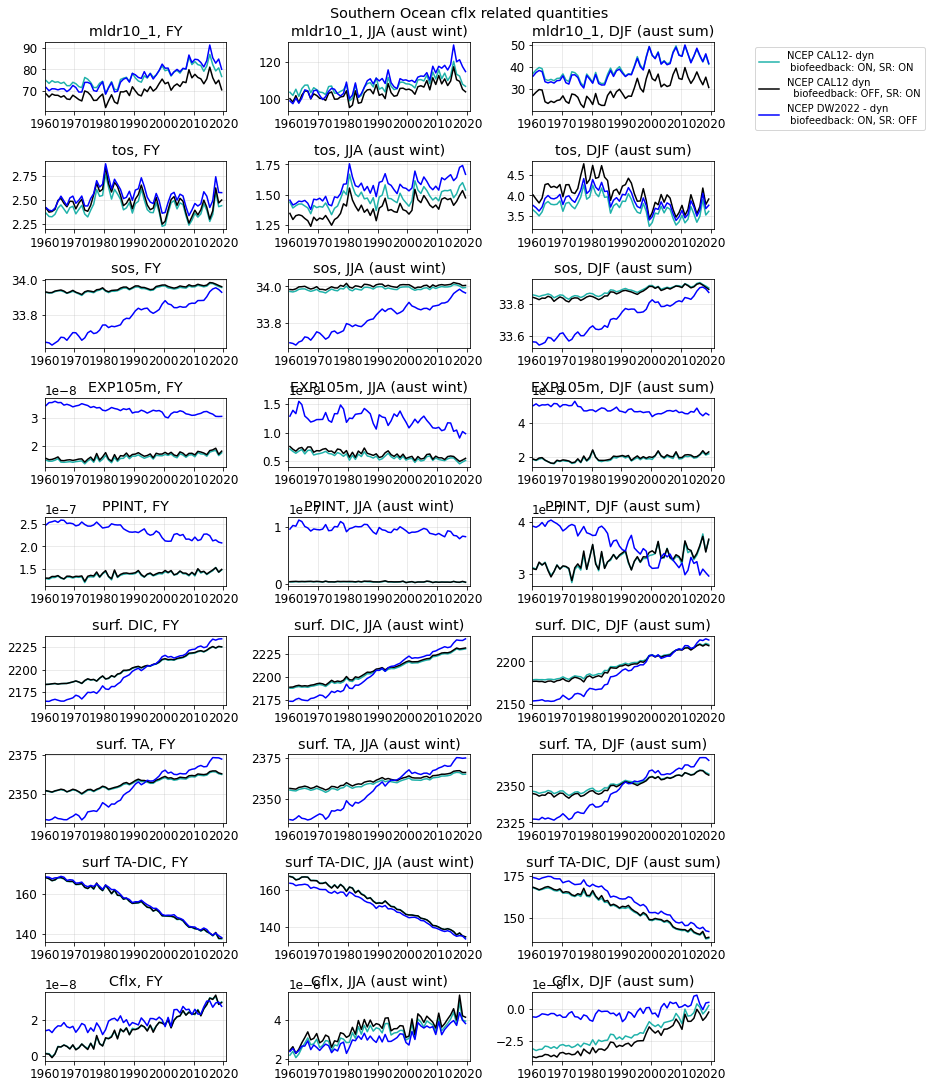

In [136]:
fact = 1.1
fig, axs = plt.subplots(9,3, figsize=(12*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

scens = ['GNAP','GNA2','GA01']

for s in range(0,len(scens)):
    plotncep_seas(scens[s],'mldr10_1',0,'gridT',1960,2019,'FY')
    plotncep_seas(scens[s],'mldr10_1',1,'gridT',1960,2019,'JJA')
    plotncep_seas(scens[s],'mldr10_1',2,'gridT',1960,2019,'DJF')
    
    ofs = 3; tvar = 'tos'
    plotncep_seas(scens[s],tvar,0+ofs,'gridT',1960,2019,'FY')
    plotncep_seas(scens[s],tvar,1+ofs,'gridT',1960,2019,'JJA')
    plotncep_seas(scens[s],tvar,2+ofs,'gridT',1960,2019,'DJF')
   
    ofs = 6; tvar = 'sos'
    plotncep_seas(scens[s],tvar,0+ofs,'gridT',1960,2019,'FY')
    plotncep_seas(scens[s],tvar,1+ofs,'gridT',1960,2019,'JJA')
    plotncep_seas(scens[s],tvar,2+ofs,'gridT',1960,2019,'DJF')
    
    ofs = 9; tvar = 'EXP105m'
    plotncep_seas(scens[s],tvar,0+ofs,'diadT',1960,2019,'FY')
    plotncep_seas(scens[s],tvar,1+ofs,'diadT',1960,2019,'JJA')
    plotncep_seas(scens[s],tvar,2+ofs,'diadT',1960,2019,'DJF')
    
    ofs = 12; tvar = 'PPINT'
    plotncep_seas(scens[s],tvar,0+ofs,'diadT',1960,2019,'FY')
    plotncep_seas(scens[s],tvar,1+ofs,'diadT',1960,2019,'JJA')
    plotncep_seas(scens[s],tvar,2+ofs,'diadT',1960,2019,'DJF')
    
    ofs = 15; tvar = 'surfDIC'
    plotncep_seas(scens[s],tvar,0+ofs,'diadT',1960,2019,'FY',1e6)
    plotncep_seas(scens[s],tvar,1+ofs,'diadT',1960,2019,'JJA',1e6)
    plotncep_seas(scens[s],tvar,2+ofs,'diadT',1960,2019,'DJF',1e6)

    ofs = 18; tvar = 'surfTA'
    plotncep_seas(scens[s],tvar,0+ofs,'diadT',1960,2019,'FY',1e6)
    plotncep_seas(scens[s],tvar,1+ofs,'diadT',1960,2019,'JJA',1e6)
    plotncep_seas(scens[s],tvar,2+ofs,'diadT',1960,2019,'DJF',1e6)
    
    ofs = 21; 
    plotncep_tadic(scens[s],0+ofs,'diadT',1960,2019,'FY',1)
    plotncep_tadic(scens[s],1+ofs,'diadT',1960,2019,'JJA',1)
    plotncep_tadic(scens[s],2+ofs,'diadT',1960,2019,'DJF',1)    
    
    
    
    ofs = 24; tvar = 'Cflx'
    plotncep_seas(scens[s],tvar,0+ofs,'diadT',1960,2019,'FY')
    plotncep_seas(scens[s],tvar,1+ofs,'diadT',1960,2019,'JJA')
    plotncep_seas(scens[s],tvar,2+ofs,'diadT',1960,2019,'DJF')
    
vars = ['mldr10_1','tos','sos','EXP105m','PPINT','surf. DIC','surf. TA','surf TA-DIC','Cflx']

for i in range(0,9):
    
    axs[i*3].set_title(f'{vars[i]}, FY')
    axs[i*3+1].set_title(f'{vars[i]}, JJA (aust wint)')
    axs[i*3+2].set_title(f'{vars[i]}, DJF (aust sum)')
    
for i in range(0,27):
#     axs[i].set_xlim([1960,2020])
#     axs[i].set_xticks(np.arange(1960,2040,20))
    axs[i].set_xlim([datetime(1960, 1, 1), datetime(2021, 1, 1)])


    axs[i].grid(alpha = 0.3)
fig.suptitle('Southern Ocean cflx related quantities')
plt.tight_layout()